<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontate para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

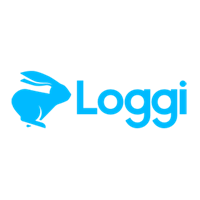

A Loggi e Uma empresa que usa a tecnologia para inovar os envios de pacotes para todo o Brasil com praticidade e no tempo que você precisa. Por aqui, a gente acredita que uma logística de qualidade é um direito de todas as pessoas.

Neste notebook, vamos explorar dados de logistica, analisar dados de entregar de pedidos como local de inicio e destino do produto, com o intuito de conhecer os hubs distribuídos no Distrito Federal (DF), bem como a proporção e os desafios que a Loggi enfrenta diante de todo esse cenário logístico de entregas.

## 2\. Pacotes e bibliotecas

In [ ]:
!pip install geopandas

In [ ]:
!pip install wget

In [4]:
import re
import urllib
import sqlite3
import datetime
import random
import math
import sys
import json
import wget
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


## 3\. Exploração de dados

#3.1. Coleta

**coleta de dados**

In [11]:
site_url = 'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json'

In [ ]:
data = wget.download(site_url)
with open(data, mode='r', encoding='utf8') as file:
 data = json.load(file)

len(data)

In [ ]:
type(data)

**wrangling da estrutura**

In [ ]:
deliveries_df = pd.DataFrame(data)
deliveries_df.head()

In [ ]:
deliveries_df.info()


O Dataframe possui 2 colunas origin e deliveries possuem dados em formato de dicionário e lista.  A coluna region possue informações de região da entrega, latitude e longitude; a coluna deliveries possui informações de id e tamanho da entrega, latitude e longitude

 Será criado um segundo dataframe utilizando o método .json_normalize.



In [ ]:
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df.head()




Depois da separação dos dados é possível juntar os dois dataframes com o método merge

In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df.head()

In [ ]:
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"},inplace=True)
deliveries_df.head()

In [ ]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_normalized_df = pd.concat([
 pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
 pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
 pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()


In [37]:
print(len(deliveries_exploded_df))

636149


In [ ]:
deliveries_exploded_df.head()

In [ ]:
deliveries_exploded_df.tail()

In [40]:
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df,how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


In [41]:
len(deliveries_df)

636149

In [42]:
deliveries_df.shape

(636149, 8)

In [43]:
deliveries_df.columns

Index(['name', 'region', 'hub_lng', 'hub_lat', 'vehicle_capacity',
       'delivery_size', 'delivery_lng', 'delivery_lat'],
      dtype='object')

In [44]:
deliveries_df.index

RangeIndex(start=0, stop=636149, step=1)

In [ ]:
deliveries_df.info()

**Exploração do schema**

In [ ]:
deliveries_df.dtypes

In [ ]:
deliveries_df.head(n=5)

In [ ]:
deliveries_df.select_dtypes("object").describe().transpose()

In [ ]:
deliveries_df.drop([], axis=1).select_dtypes('int64').describe().transpose()

**Dados faltantes**

In [ ]:
deliveries_df.isna().any()

In [54]:
def count_missing_values(vec):
    null = pd.isnull(vec)
    null_count = np.sum(null)
    return null_count

def prop_missing_values(vec):
    num = count_missing_values(vec)
    dem = vec.size
    return num / dem

def prop_complete_values(vec):
    return 1 - prop_missing_values(vec)

Soma dos valores ausentes

In [ ]:
count_nan = deliveries_df.apply(count_missing_values)
print(count_nan)

Proporção dos valores ausentes

In [ ]:
prop_nan = deliveries_df.apply(prop_missing_values)
print(prop_nan)

Proporção dos valores não ausentes

In [57]:
prop_complete = deliveries_df.apply(prop_complete_values)
print(prop_complete)

name                1.0
region              1.0
hub_lng             1.0
hub_lat             1.0
vehicle_capacity    1.0
delivery_size       1.0
delivery_lng        1.0
delivery_lat        1.0
dtype: float64


## 4\. Manipulação

**enriquecimento**

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

In [ ]:
import json

import geopy
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

In [ ]:
from geopy.extra.rate_limiter import RateLimiter

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df= hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

In [ ]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df.head()

In [ ]:
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

In [ ]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

In [ ]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

In [72]:
!pip install h3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00


In [73]:
import h3


In [ ]:
deliveries_df['distance'] = deliveries_df.apply(lambda row: h3.point_dist((row['hub_lat'], row['hub_lng']), (row['delivery_lat'], row['delivery_lng']), unit='km'), axis=1)
deliveries_df.head()

**controle de qualidade**

In [ ]:
deliveries_df.info()

In [ ]:
deliveries_df.isna().any()

In [ ]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

In [ ]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

In [ ]:
prop_df = deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

In [ ]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

In [ ]:
deliveries_df.select_dtypes(include=['int64', 'float64']).describe().T

In [ ]:
deliveries_df.select_dtypes('object').describe().T

In [ ]:
deliveries_df.query('region == "df-0"').describe().T

In [ ]:
deliveries_df.query('region == "df-1"').describe().T

In [ ]:
deliveries_df.query('region == "df-2"').describe().T

## 5\. Visualização

In [ ]:
!pip3 install geopandas;

#Mapa do Distrito Federal

Vamos fazer o download dos dados do mapa do Distrito Federal do site oficial do IBGE através do seguinte link para criar o DataFrame mapa. Note a coluna geometry.

In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

Mapa dos Hubs

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

Mapa das Entregas

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

Visualização

<ipython-input-93-ebc4296b35c6>:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


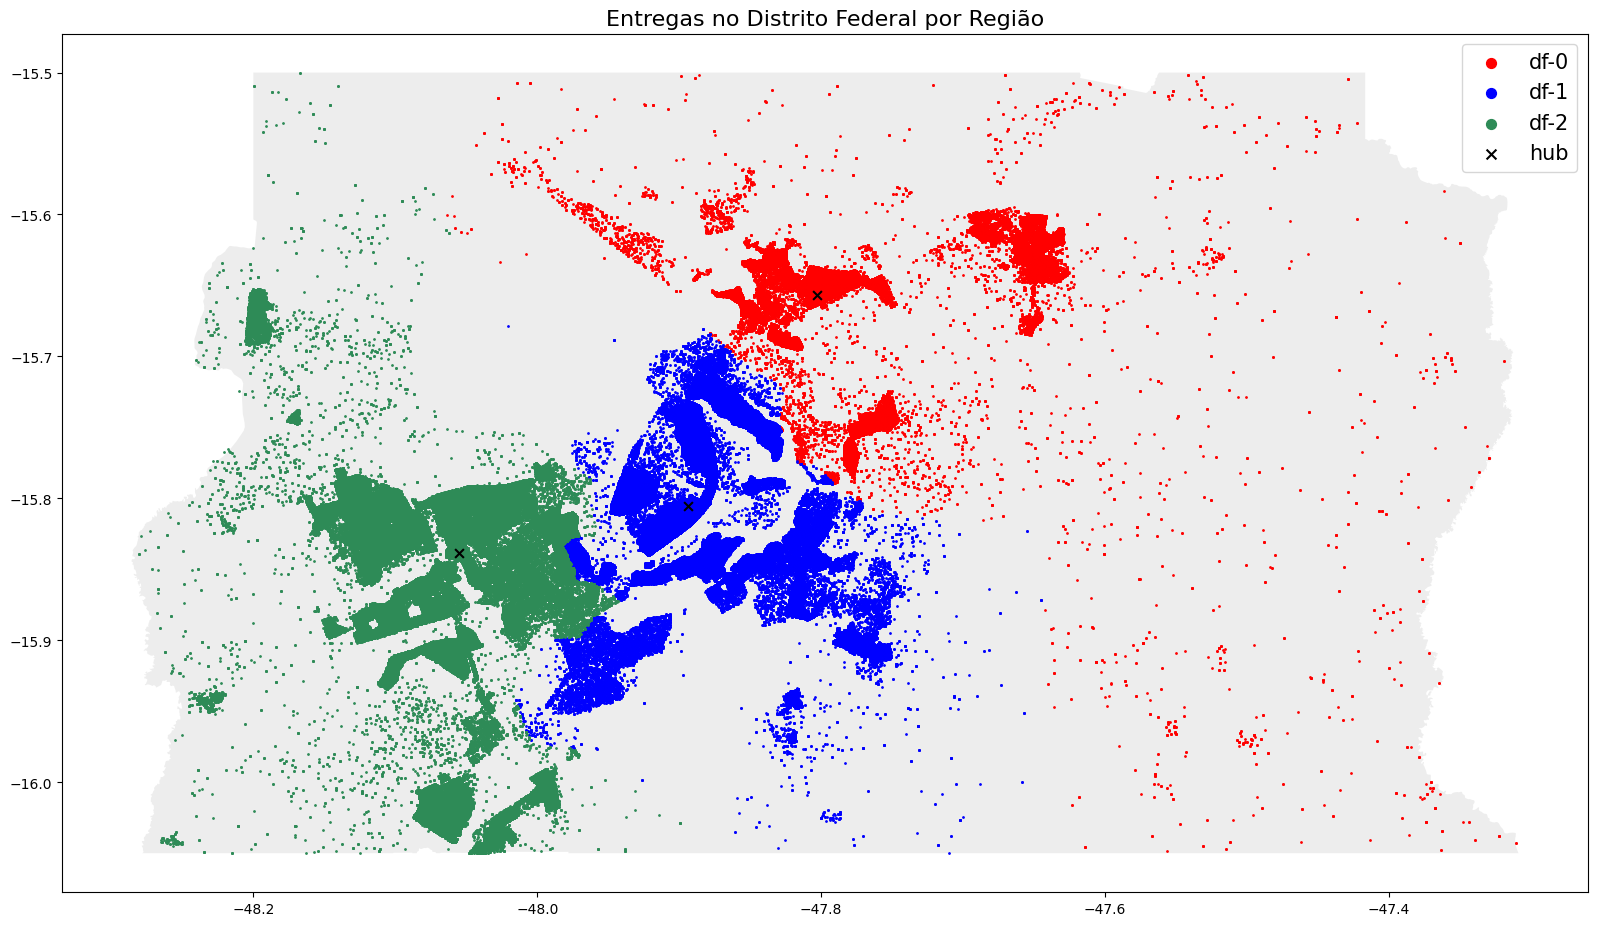

In [93]:
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=40, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])
plt.show()

Insights

As entregas parecem estar corretamente alocadas em seus respectivos Hubs. A distância média percorrida para a realização de uma entrega considerando os três hubs é de 7.1 km, e a distância mediana é de 5.53km.

No entanto, como os Hubs das regiões 0 e 2 fazem entregas em locais mais distantes do centro, isso pode gerar um tempo e preço de entrega maiores.

Agregação:

In [99]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


Grafico 1

In [ ]:
with sns.axes_style('whitegrid'):
    grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="bright")
    grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

Insights

Como foi observado através do mapa entregas está concentrada hub df - 0 possui rotas com maior distância e o df-1, o que justifica a alocação de mais veículos para esses centros.

grafico 2

In [ ]:
with sns.axes_style('whitegrid'):
  plt.subplots(figsize=(10, 8))
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="bright")
  grafico.set(title='Quantidade de entregas por cidade de destino', xlabel='quantidade de entregas', ylabel='Cidade de destino');

Quantidade de entregas por cidade de destino

In [104]:
data = pd.DataFrame(deliveries_df[['delivery_city']].value_counts()).reset_index()
data.rename(columns={0: "delivery_amount_per_city"}, inplace=True)
data.head()

,delivery_city,delivery_amount_per_city
0,Brasília,148983
1,Taguatinga,45564
2,Sudoeste / Octogonal,44215
3,Ceilândia,37953
4,Águas Claras,37083


<ipython-input-103-eded8da32d88>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="delivery_amount_per_city", y="delivery_city", ci=None, palette="bright")
<ipython-input-103-eded8da32d88>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="delivery_amount_per_city", y="delivery_city", ci=None, palette="bright")


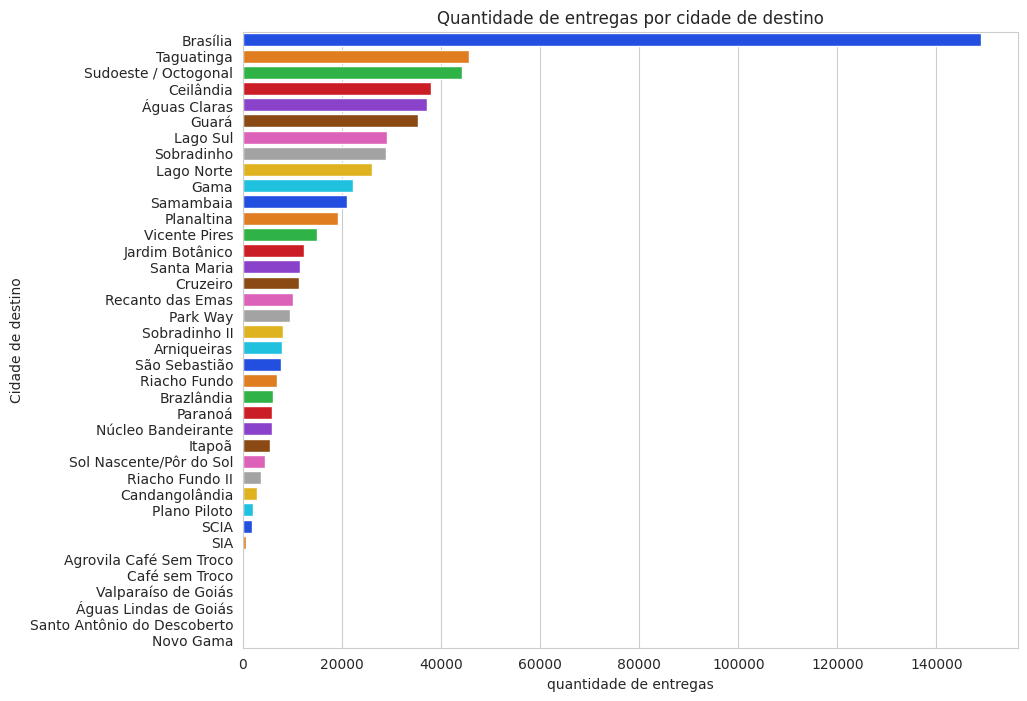

In [103]:
with sns.axes_style('whitegrid'):
  plt.subplots(figsize=(10, 8))
  grafico = sns.barplot(data=data, x="delivery_amount_per_city", y="delivery_city", ci=None, palette="bright")
  grafico.set(title='Quantidade de entregas por cidade de destino', xlabel='quantidade de entregas', ylabel='Cidade de destino');

Insights

Mais uma vez vemos que há uma concentração de entregas em Brasília, onde está localizado o Hub df-1. Isso justifica, de certa forma, uma concentração maior dos veículos de entrega nesse Hub. Entretanto, há também uma dispersão de entregas em outras regiões. De novo, se olharmos o mapa, vemos que o Hub de Sobradinho possui entregas distantes do centro de distribuição, ao mesmo tempo que possui menos veículos de entrega quando comparado com outros Hubs.